# Question 1

Discuss different approaches you could take to estimate which inventory fits a given client. Explain which data sources you considered and which approaches/algorithms are possible. Bonus points for using descriptive statistics to understand trade-offs between different approaches.

At a high-level this assignment fits a canonical form in data science of designing a recommendation system.  The system is responsible for returning a predicted set of user-specific items of interest.  Classically, there are two ways of inferring user interest in an item: content-based and collaborative-based filtering.  In the first, item-to-item similarity is deduced, and items are suggested to a user based upon what they have evaluated highly in the past.  In the second user-to-user similarity is measured and used to advance item recommendations.

For the specific problem of taking the data supplied and ultimately producing item recommendations on the basis of fit, the decision to pursue one of these filtering strategy or the other turns on the result of a number of questions
- What style or sku specific data is available.  For content-based filtering we need an explicit basis of features to paramatize the items, and this basis should be sufficient to explain user-item fit.  
- How are user-item interactions recorded in the data?  It appears that overall satisfaction is measured via a likert scale of "loved it", "liked it", "just okay," however, we're exclusively interested in feedback as it pertains to clothing fit.  This is measured with a more complex relationship in the data wherein, under certain situations, fit satisfaction is recorded via a binary feature, and in the event of fit disatisfaction, more specific feedback is collected.  
- How sparse is the user-item matrix?  
- How important are user features

- ultimately I decided to go with a collaborative filtering approach.

## Matrix factorization

I chose to tackle the collaborative filtering problem via matrix factorization.  Here, we wish to minimize the the difference between the original user-item matrix, $R$, and a reconstruction of it formed from a low rank factorization, $\hat{R}$.  The objective function the takes the form: 

\begin{alignat*}{2}
&\textrm{min} \quad &&\sum_{(u,i) \in R} \; (R_{ui} - \hat{R}_{ui}) \\
&\textrm{subject to} \quad &&\textrm{Rank}\left(\hat{R}\right)=k
\end{alignat*}

where the elements of $\hat{R}$ are expressed as
$$
\hat{r}_{ui} = \mu + b_i + b_u + q_i^T \left(p_u + |N(u)|^{-.5} \sum_{j \in N(u)} y_j \right)
$$
The terms $\mu$, $b_i$, and $b_u$ make up the baseline model for the user-item rating.  $\mu$ represents an overall bias for the entire matrix, and corresponds to how well clothing fits users on  average bias, 

In [2]:
# imports and jupyter nb settings
# best params k=70, alpha = .002, beta=.001, beta=.05
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from scipy import sparse
import math

%matplotlib inline

In [3]:
# constants
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

#Read in data
orders = pd.read_csv(ORDERS)
reviews = pd.read_csv(REVIEWS)
#size_mappings = pd.read_csv(SIZE_MAPPINGS)
style_attr = pd.read_csv(STYLE_ATTR)
user_attr = pd.read_csv(USER_ATTR)


In [4]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit
 
 ## Collobartive Filtering 
 


In [5]:
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.drop_duplicates(inplace=True)
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1228395,1228395,1228395,1228395,1228395,1228395,1.228395e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,24564ced-ca3a-3ee8-ae75-273b3b8439aa,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,1,307,9436,12296,1549,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.242047e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997819e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


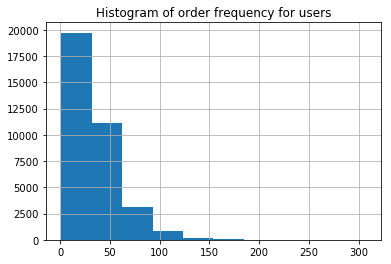

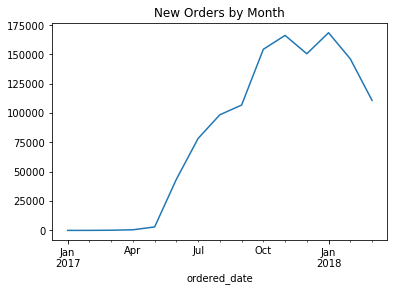

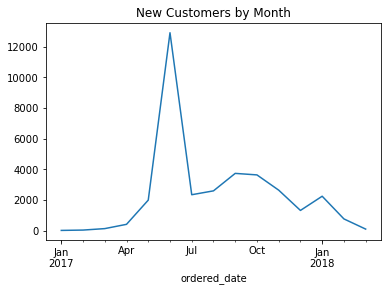

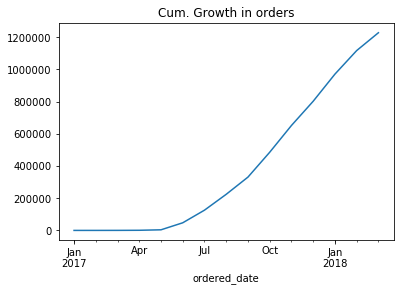

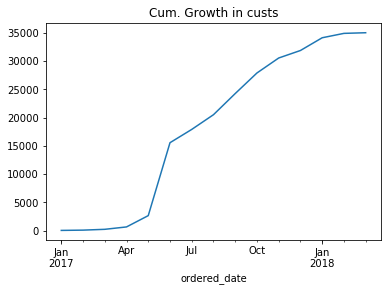

In [6]:
def make_orders_plots(df):
    _df = df.copy()
    
    plt.figure()
    ax = plt.gca()
    _df[['user_id']].apply(pd.value_counts).hist(ax=ax)
    ax.set_title("Histogram of order frequency for users")

    
    _df = _df.set_index("ordered_date").sort_index()
    _df['order_cnt'] = 1
    _df['cust_cnt'] = ~_df['user_id'].duplicated()
    _df['order_cum'] = _df['order_cnt'].cumsum()
    _df['cust_cum'] = _df['cust_cnt'].cumsum()
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Orders by Month")

    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Customers by Month")
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in orders")
    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in custs")

make_orders_plots(orders)

In [7]:
from pandas.api.types import CategoricalDtype
reviews.drop_duplicates(inplace=True)
reviews['did_you_wear_it'] = reviews['did_you_wear_it'].astype('category')

like_it_cat_type = CategoricalDtype(categories=['just_okay', 'liked_it', 'loved_it'], ordered=True)
reviews['how_did_you_like_it'] = reviews['how_did_you_like_it'].astype(like_it_cat_type)

reviews['didnt_fit'] = reviews['didnt_fit'].astype('category')
reviews['size_overall'] = reviews['size_overall'].astype('category')
reviews['size_chest'] = reviews['size_chest'].astype('category')
reviews['size_waist'] = reviews['size_waist'].astype('category')
reviews['size_waist.1'] = reviews['size_waist.1'].astype('category')
reviews['length'] = reviews['length'].astype('category')
reviews['not_flattering'] = reviews['not_flattering'].astype('category')
reviews['not_my_style'] = reviews['not_my_style'].astype('category')
reviews['other_issue'] = reviews['other_issue'].astype('category')

In [8]:
#reviews = to_dates(reviews, ['reviewed_date'])
reviews.describe(include='all')
#reviews.size_overall.value_counts()

,order_id,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
count,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395
unique,1228395,287,2,3,2,4,4,4,4,4,4,2,2,2
top,24564ced-ca3a-3ee8-ae75-273b3b8439aa,2018-03-06,1,loved_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
freq,1,9536,832228,490571,1092882,1092882,1092882,1092882,1092882,1092882,1092882,1103353,1175706,1116430


In [9]:
unique_users = orders['user_id'].unique()
np.random.choice(unique_users, int(.1*len(unique_users)))

array(['bb388c56-97da-39ff-90aa-06b3985c77c3',
       'c5663b4e-1e9a-3788-b386-26ee70bdc915',
       'd54b8ac6-42e4-3247-b11d-7c70b1fef3be', ...,
       '56f5ea12-1f6a-3bfd-b1fa-1dfca52a39de',
       '7aed1e17-ed44-34c5-95a7-3f8b8a74b385',
       'c604a43c-2810-363b-b0fb-550c0c5681d1'], dtype=object)

In [10]:
orders

,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
0,9f965f2a-b0e3-3d26-87b7-127d9d4a2e50,45cb184f-aadc-38cd-b1ef-1c59767938d1,2017-08-20,2017-08-23,BL28,BL28_XS,21
1,d56facba-011a-3428-95e8-94c0805d1b28,bd189738-87ac-359c-b1e9-ede06fb124cf,2018-03-14,2018-03-20,BL28,BL28_XS,7
2,9b5e7364-b5bf-32f7-85a3-6763981d5e4a,2c70d192-3e1e-3b54-85a9-5347d1e94519,2017-07-07,2017-07-11,BL28,BL28_XS,1
3,eab2dd20-4392-3ecd-9a0c-182c828846d3,ab180e14-8bd1-30ae-9653-a97fd3fa2119,2017-07-25,2017-07-27,BL28,BL28_XS,4
4,159ad641-460c-365a-be48-fa45e8ca1b5b,556d7fc6-7efb-379e-aa0e-1da0dabcc97f,2017-08-02,2017-08-07,BL28,BL28_XS,8
5,d31e9cb3-6f5b-3195-91a8-3c3d8a7de67a,80fd4e90-52ee-3e41-96e7-98adc77e6317,2017-08-09,2017-08-11,BL28,BL28_XS,3
6,ddf0eda4-758c-3ff9-b82c-67092d29b8b4,136a2382-e5ba-3806-94ec-0498dc422030,2017-08-16,2017-08-17,BL28,BL28_XS,7
7,9171cb26-8d2e-3312-9e3e-c4a0f41efc9c,e660afe3-192a-3510-bbfb-4d474f046ce9,2017-09-22,2017-09-27,BL28,BL28_XS,1
8,ee2e2724-729f-3163-a39b-4895a3a8e659,2324c782-5f1f-3859-9941-b48dd1c35ce6,2017-10-26,2017-10-30,BL28,BL28_XS,6
9,aa373c81-aa7f-3825-9e08-352e198fb12d,694ed2dc-24c5-31b9-946b-bb3db251b054,2017-08-09,2017-08-11,BL28,BL28_S,11


In [19]:
def prepare_data(orders_df, reviews_df, thin_users, thin_styles):
    
    unique_users = orders['user_id'].unique()
    thinned_users = np.random.choice(unique_users, int(len(unique_users)*thin_users), replace=False)
    
    unique_styles = orders['style'].unique()
    thinned_styles = np.random.choice(unique_styles, int(len(unique_styles)*thin_styles), replace=False)
    
    _orders_df = orders_df.copy()
    _reviews_df = reviews_df.copy()
    
    _orders_df = _orders_df[_orders_df['user_id'].isin(thinned_users)]
    _orders_df = _orders_df[_orders_df['style'].isin(thinned_styles)]
    
    _orders_df.set_index("order_id", inplace=True)
    joined = _reviews_df.join(_orders_df, how='left', on="order_id")
    joined = joined[['user_id','style','didnt_fit']]
    joined['didnt_fit'] = joined['didnt_fit'].astype(int)
    joined.loc[joined['didnt_fit'] == 0, 'didnt_fit'] = 10
    return joined.groupby(['user_id','style'])['didnt_fit'].mean().unstack()

def data2sparse(df, training_prop, testing_prop):
    (x_inds, y_inds) = np.nonzero(~np.isnan(df.values))
    n = len(x_inds)
    inds = np.random.choice(n, int((training_prop+testing_prop)*n), replace=False)
    train_inds = np.random.choice(
        inds, int(training_prop/(training_prop + testing_prop)*len(inds)), replace=False
    ) 
    inds = set(inds)
    train_inds = set(train_inds)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(n):
        if i not in inds:
            continue
        else:
            if i in train_inds:
                train_x.append(x_inds[i])
                train_y.append(y_inds[i])
            else:
                test_x.append(x_inds[i])
                test_y.append(y_inds[i])

    train = [train_x, train_y]
    test = [test_x, test_y]
    train_sparse = sparse.dok_matrix(sparse.coo_matrix((df.values[train], train), shape = df.shape))
    test_sparse = sparse.dok_matrix(sparse.coo_matrix((df.values[test], test), shape = df.shape))
    return (train_sparse, test_sparse)
    
g = prepare_data(orders, reviews, thin_users=.1, thin_styles=.1)
print(g.shape)
(train_raw, test_raw) = data2sparse(g, .95, .05)
print("TRAINING SHAPE {}; NNZ: {}; Sparsity {:0.4f}%".format(
    train_raw.shape, train_raw.nnz, 100*(1 - (train_raw.nnz / (train_raw.shape[0] * train_raw.shape[1]))))
     )
print("TESTING SHAPE {}; NNZ: {}; Sparsity {:0.4f}%".format(
    test_raw.shape, test_raw.nnz, 100*(1 - (test_raw.nnz / (test_raw.shape[0] * test_raw.shape[1]))))
     )

(3202, 400)
TRAINING SHAPE (3202, 400); NNZ: 11267; Sparsity 99.1203%
TESTING SHAPE (3202, 400); NNZ: 594; Sparsity 99.9536%


In [15]:
g.shape

(681, 836)

In [268]:


print(list(train_raw.items())[:10])


[((27, 0), 1.0), ((33, 0), 10.0), ((438, 0), 10.0), ((466, 0), 10.0), ((689, 0), 10.0), ((712, 0), 10.0), ((1427, 0), 10.0), ((1535, 0), 1.0), ((1548, 0), 10.0), ((1609, 0), 10.0)]


In [269]:
SIZE_INCR = 1
HEIGHT_INCR = 1
WEIGHT_INCR = 1
BMI_INCR = .5

def make_user_attrib_dict():
    _df = user_attr.copy()
    _df['bmi'] = (_df['weight_lbs'] / _df['height_in'].pow(2))*703
    _df['size_bin'] = np.floor((_df['standard_size']  - _df['standard_size'].min()) / SIZE_INCR)
    _df['height_bin'] = np.floor((_df['height_in']  - _df['height_in'].min()) / HEIGHT_INCR)
    _df['weight_bin'] = np.floor((_df['weight_lbs']  - _df['weight_lbs'].min()) / WEIGHT_INCR)
    _df['bmi_bin'] = np.floor((_df['bmi']  - _df['bmi'].min()) / BMI_INCR)
    _df.drop(["standard_size","height_in","weight_lbs","bmi"], axis=1, inplace=True)
    index_df = pd.DataFrame(g.index)
    _df.set_index('user_id', inplace=True)
    df = index_df.join(_df,on='user_id',how='left')
    return(df.to_dict('records'))

def make_userId2idx_dict():
    d = user_attr['user_id'].to_dict()
    d = {v: k for k, v in d.items()}
    return d

user_attrib_dict = make_user_attrib_dict()
userId2idx_dict = make_userId2idx_dict()
style_names = list(g.columns)

In [270]:
df = pd.DataFrame(user_attrib_dict)

In [271]:
df['weight_bin'].max()

180.0

In [272]:
class UserStyleMat(object):
    '''
    data structure with convenience functions for matrix factorization.
    '''
    
    def __init__(self, data, user_attrib_dict, userId2idx_dict, style_names):
        
        self.data = data
        self.user_attrib_dict = user_attrib_dict
        self.style_names = style_names
        self.userId2idx_dict = userId2idx_dict
        
        df = pd.DataFrame(user_attrib_dict)
        
        self.n_sizes = df['size_bin'].max()  + 1
        self.n_heights = df['height_bin'].max()  + 1
        self.n_weights = df['weight_bin'].max()  + 1
        self.n_bmis = df['bmi_bin'].max()  + 1
        
    def get_user_params(self, idx):
        return self.user_attrib_dict[idx]
    
    def userid2idx(self, user_id):
        return self.userId2idx_dict[user_id]
        
    
    

In [273]:
train = UserStyleMat(train_raw, user_attrib_dict, userId2idx_dict, style_names)
test = UserStyleMat(test_raw, user_attrib_dict, userId2idx_dict, style_names)

train.n_sizes
np.mean(train.data)
np.mean(list(train.data.values()))

9.017951753323018

In [274]:
class MF():

    def __init__(self, training_USM, testing_USM, K, alpha, beta1, beta2, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (UserStyleMat)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        - iterations    : number of iterations to run for
        """
                        
        self.training_USM = training_USM
        self.testing_USM = testing_USM
        self.num_users, self.num_items = training_USM.data.shape
        self.K = K
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = iterations
        

    def get_feature_vec(self, bin_idx, feature_vec):
        """
        get the feature vector associated with a bin index.  If bin_indx is NaA return zeros
        """
        if np.isnan(bin_idx):
            vec = np.zeros(self.K)
            indicator = 0
        
        else:
            bin_idx = int(bin_idx)
            vec = feature_vec[bin_idx, :]
            indicator = 1
        
        return (vec, indicator)
    
    def set_feature_vec(self, bin_idx, feature_vec, val):
        """
        set the feature vector at bin_idx to val.
        """
        if np.isnan(bin_idx):
            return
        
        else:
            bin_idx = int(bin_idx)
            feature_vec[bin_idx, :] = val
        return
    
    def get_all_feature_vecs(self, user_idx):
        """
        for a given user id, return all feature vectors and cardinality of this set.
        """
        user_dict = self.training_USM.get_user_params(user_idx)
        (size_vec, size_indic) = self.get_feature_vec(user_dict['size_bin'], self.sizes)
        (height_vec, height_indic) = self.get_feature_vec(user_dict['height_bin'], self.heights)
        (weight_vec, weight_indic) = self.get_feature_vec(user_dict['weight_bin'], self.weights)
        (bmi_vec, bmi_indic) = self.get_feature_vec(user_dict['bmi_bin'], self.bmis)
        
        cardinality = size_indic + height_indic + weight_indic + bmi_indic
        cardinality = max(cardinality, 1)
        return(size_vec, height_vec, weight_vec, bmi_vec, cardinality)

    def set_all_feature_vecs(self, user_idx, size_vals, height_vals, weight_vals, bmi_vals):
        """
        set all feature vectors for a given user
        """
        user_dict = self.training_USM.get_user_params(user_idx)
        self.set_feature_vec(user_dict['size_bin'], self.sizes, size_vals)
        self.set_feature_vec(user_dict['height_bin'], self.heights, height_vals)
        self.set_feature_vec(user_dict['weight_bin'], self.weights, weight_vals)
        self.set_feature_vec(user_dict['bmi_bin'], self.bmis, bmi_vals)
        return
    
    def train(self):
        print("Training for k={}; alpha={}; beta1={}; beta2={}".format(self.K, self.alpha, self.beta1, self.beta2))
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.training_USM.data)
        
        # Initialize the additional user latent feature matrices.
        self.sizes = np.random.normal(scale=1./self.K, size=(int(self.training_USM.n_sizes), self.K))
        self.heights = np.random.normal(scale=1./self.K, size=(int(self.training_USM.n_heights), self.K))
        self.weights = np.random.normal(scale=1./self.K, size=(int(self.training_USM.n_weights), self.K))
        self.bmis = np.random.normal(scale=1./self.K, size=(int(self.training_USM.n_bmis), self.K))

        # Create a list of training samples
        self.samples = [
            (i[0][0], i[0][1], i[1])
            for i in self.training_USM.data.items()
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        rmse_train_baseline = self.rmse_baseline(self.training_USM.data)
        rmse_test_baseline = self.rmse_baseline(self.testing_USM.data)
        epoch = 0
        exit_code = 0
        while (epoch < self.iterations) and (exit_code == 0):
            np.random.shuffle(self.samples)
            exit_code = self.sgd()
            rmse_train = self.rmse(self.training_USM.data)
            rmse_test = self.rmse(self.testing_USM.data)
            training_process.append((epoch, rmse_train, rmse_train_baseline, rmse_test, rmse_test_baseline))
            epoch += 1
            if (epoch) % 5 == 0:
                print("Epoch: %d\n" \
                "\ttrain_err = %.4f; train_baseline_err = %.4f\n" \
                      "\ttest_err = %.4f; test_baseline_err = %.4f" % (
                          epoch, rmse_train, rmse_train_baseline, rmse_test, rmse_test_baseline)
                     )

            self.alpha = .9*self.alpha
            
        
        test_errors = [tp[3] for tp in training_process]
        best_test_error = min(test_errors)
        print("BEST TEST: {}".format(best_test_error))
        return (best_test_error, ((self.K, self.alpha, self.beta1, self.beta2)))

    def rmse(self, data):
        """
        A function to compute the total mean square error
        """
        
        error = 0
        n = data.nnz
        for (x, y) in data.keys():
            (size_vec, height_vec, weight_vec, bmi_vec, cardinality) = self.get_all_feature_vecs(x)
            user_vec = cardinality**(-.5)*(size_vec + height_vec + weight_vec + bmi_vec)
            error += pow(data[x, y] - self.get_rating(x,y,user_vec), 2)
        return np.sqrt(error/n)
    
    def rmse_baseline(self, data):
        """
        compute rmse error w.r.t. a baseline predictor that always guess average value.
        """
        error = 0
        n = data.nnz
        mean_nz = np.mean(list(data.values()))
        for (x, y) in data.keys():
            error += pow(data[x, y] - mean_nz, 2)
        return np.sqrt(error/n)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        counter = 0
        for i, j, r in self.samples:
         
            (size_vec, height_vec, weight_vec, bmi_vec, cardinality) = self.get_all_feature_vecs(i)
            user_vec = cardinality**(-.5)*(size_vec + height_vec + weight_vec + bmi_vec)

            # Computer prediction and error
            prediction = self.get_rating(i, j, user_vec)
            e = (r - prediction)
            if(np.isnan(e)):
                print("Terminating SGD: Gradients became badly conditioned " \
                      "increase regularization or decrease stepsize")
                return(1)
        
            self.b_u[i] += self.alpha * (e - self.beta1 * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta1 * self.b_i[j])

            # Update user and item latent feature matrices
            self.Q[j, :] += self.alpha * (e * (self.P[i, :]+user_vec) - self.beta2 * self.Q[j,:])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta2 * self.P[i,:])
            
            # update user features
            size_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * size_vec)
            height_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * height_vec)
            weight_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * weight_vec)
            bmi_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * bmi_vec)
            
            self.set_all_feature_vecs(i, size_vec, height_vec, weight_vec, bmi_vec)
        return(0)

    def get_rating(self, i, j, user_vec):
        """
        Get the predicted rating of user i and item j
        """           
        prediction = self.b + self.b_u[i] + self.b_i[j] + (self.P[i, :] + user_vec).dot(self.Q[j, :].T)
        return prediction
    
    def predict_for_user(self, user_id):
        """
        Get items sorted by predicted fit for a user in training set.  User bias and 
        """
        i = self.user_id2idx.get(user_id, None)
        if(not i):
            raise ValueError('User Id not found in data')
        else:
            (size_vec, height_vec, weight_vec, bmi_vec, cardinality) = self.get_all_feature_vecs(x)
            user_vec = cardinality**(-.5)*(size_vec + height_vec + weight_vec + bmi_vec)
            
            predictions = self.b + self.b_u[i] + self.b_i + np.matmul(self.Q, (self.P[i, :] + user_vec).T)
            d = {'Score': predictions, 'Style': self.style_names}
            return pd.DataFrame(d).sort_values('Score')
            
        

#     def full_matrix(self):
#         """
#         Computer the full matrix using the resultant biases, P and Q
#         """
#         return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [275]:
def run_gridsearch():
    best = np.inf
    ranks = [i for i in range(30, 201, 10)]
    alphas = [.001, .005, .01]
    beta1s = [.001, .01, .1]
    beta2s = [.001, .01, .1]
    for r in ranks:
        for a in alphas:
            for b1 in beta1s:
                for b2 in beta2s:
                    model = MF(train, test, r, a, b1, b2, 20)
                    (train_err, params) = model.train()
                    if train_err < best:
                        best = train_err
                        best_params = params
                    print("BEST SO FAR {} WITH PARAMS {}".format(best, best_params))
    
    return best, best_params
                    

In [264]:
model = MF(train, test, 50, .002, .002, .002, 30)

In [ ]:
run_gridsearch()

Training for k=20; alpha=0.0001; beta1=0.0001; beta2=0.0001
Epoch: 5
	train_err = 9.1422; train_baseline_err = 2.7770
	test_err = 9.1127; test_baseline_err = 2.8657
Epoch: 10
	train_err = 9.0057; train_baseline_err = 2.7770
	test_err = 8.9806; test_baseline_err = 2.8657
Epoch: 15
	train_err = 8.9143; train_baseline_err = 2.7770
	test_err = 8.8929; test_baseline_err = 2.8657
Epoch: 20
	train_err = 8.8496; train_baseline_err = 2.7770
	test_err = 8.8313; test_baseline_err = 2.8657
Epoch: 25
	train_err = 8.8044; train_baseline_err = 2.7770
	test_err = 8.7886; test_baseline_err = 2.8657
Epoch: 30
	train_err = 8.7743; train_baseline_err = 2.7770
	test_err = 8.7603; test_baseline_err = 2.8657
BEST TEST: 8.76025765512414
BEST SO FAR 8.76025765512414 WITH PARAMS (20, 4.239115827521624e-06, 0.0001, 0.0001)
Training for k=20; alpha=0.0001; beta1=0.0001; beta2=0.001
Epoch: 5
	train_err = 9.1400; train_baseline_err = 2.7770
	test_err = 9.1111; test_baseline_err = 2.8657
Epoch: 10
	train_err = 8.993

Epoch: 10
	train_err = 9.0045; train_baseline_err = 2.7770
	test_err = 8.9790; test_baseline_err = 2.8657
Epoch: 15
	train_err = 8.9113; train_baseline_err = 2.7770
	test_err = 8.8891; test_baseline_err = 2.8657
Epoch: 20
	train_err = 8.8444; train_baseline_err = 2.7770
	test_err = 8.8251; test_baseline_err = 2.8657
Epoch: 25
	train_err = 8.7974; train_baseline_err = 2.7770
	test_err = 8.7805; test_baseline_err = 2.8657
Epoch: 30
	train_err = 8.7660; train_baseline_err = 2.7770
	test_err = 8.7507; test_baseline_err = 2.8657
BEST TEST: 8.750700248367583
BEST SO FAR 8.656284441040382 WITH PARAMS (20, 4.239115827521624e-06, 0.01, 0.001)
Training for k=20; alpha=0.0001; beta1=0.01; beta2=0.1
Epoch: 5
	train_err = 9.1424; train_baseline_err = 2.7770
	test_err = 9.1122; test_baseline_err = 2.8657
Epoch: 10
	train_err = 9.0082; train_baseline_err = 2.7770
	test_err = 8.9818; test_baseline_err = 2.8657
Epoch: 15
	train_err = 8.9231; train_baseline_err = 2.7770
	test_err = 8.8995; test_baseline

Epoch: 20
	train_err = 2.5870; train_baseline_err = 2.7770
	test_err = 2.9290; test_baseline_err = 2.8657
Epoch: 25
	train_err = 2.5752; train_baseline_err = 2.7770
	test_err = 2.9247; test_baseline_err = 2.8657
Epoch: 30
	train_err = 2.5684; train_baseline_err = 2.7770
	test_err = 2.9220; test_baseline_err = 2.8657
BEST TEST: 2.9219830562496485
BEST SO FAR 2.900534005125532 WITH PARAMS (20, 4.239115827521624e-05, 0.0001, 0.01)
Training for k=20; alpha=0.001; beta1=0.001; beta2=0.001
Epoch: 5
	train_err = 2.7584; train_baseline_err = 2.7770
	test_err = 3.0705; test_baseline_err = 2.8657
Epoch: 10
	train_err = 2.6485; train_baseline_err = 2.7770
	test_err = 2.9685; test_baseline_err = 2.8657
Epoch: 15
	train_err = 2.6086; train_baseline_err = 2.7770
	test_err = 2.9396; test_baseline_err = 2.8657
Epoch: 20
	train_err = 2.5897; train_baseline_err = 2.7770
	test_err = 2.9237; test_baseline_err = 2.8657
Epoch: 25
	train_err = 2.5794; train_baseline_err = 2.7770
	test_err = 2.9174; test_base

In [42]:
what = test.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb")
what[what['Style'] == 'TH71']#880

,Score,Style
3517,6.628102,TH71


In [46]:
test.rmse(testing)

2.587157589134928

In [203]:
import pickle
filehandler = open("MF.obj","wb")
pickle.dump(test,filehandler)
filehandler.close()

file = open("MF.obj",'rb')
object_file = pickle.load(file)
file.close()

print(object_file.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb"))

          Score  Style
3917   3.906105  WVG18
600    4.825705   CEL8
1830   4.838395   KP55
2604   4.869741   OS36
11     5.044118  ABR11
2415   5.435095  NLS15
2316   5.446967   MRR9
2627   5.521895  PK141
1374   5.569621   FP88
2446   5.684567   NLS5
2393   5.721950   NK39
1831   5.723746   KP57
1416   5.746869   GOJ6
225    5.767555   AX58
3202   5.818813  SLN22
2031   5.923622   LKL6
3359   5.926568  SW399
3214   5.932215  SLR19
752    5.985428  CVN77
166    6.005394   AQ25
1125   6.013031  EFA21
1920   6.048425   KS70
640    6.059610    CP3
601    6.068187   CEL9
2545   6.074815   NR53
2323   6.093930  MRW16
720    6.108166  CVN20
19     6.123770  ADE15
719    6.169246  CVN19
198    6.187415   AX28
...         ...    ...
1232  10.300170    EM7
2747  10.303848   PR62
2903  10.306691  RT120
3553  10.306747  TLR14
3522  10.308260   TH78
710   10.322140   CUP9
3849  10.322298   VIN4
2871  10.323043   RM78
1238  10.330387   EMS7
3846  10.333279  VIN37
3759  10.336462  TYB37
1583  10.33

In [209]:
orders_df = orders[orders['user_id'] == "000966f4-c977-3a9d-8477-8825fa6084bb"]
temp_df = reviews.set_index('order_id')
orders_df.join(temp_df, how="left")
#reviews[reviews.order_id.isin(order_ids)]
#orders.loc['order_id' == "9f965f2a-b0e3-3d26-87b7-127d9d4a2e50"]
#orders[orders['user_id'] == "0001b9a8-0a05-3677-9e1d-7fc05a9a9b67"]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
192388,20185341-5d3b-38a1-b082-6f249392d410,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,DVF99,DVF99_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278841,eebbcefb-412c-3bf0-8fca-50b6d7240a23,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,TH71,TH71_8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387385,171a4c9b-6e77-3153-8949-e9afc4766552,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,JWG2,JWG2_S,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542576,45c8ad8a-8464-39cb-b41e-6c8d7ee4c35c,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,KPL26,KPL26_MR,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549090,ddf56429-3df9-39b2-88ce-8576b9f37ca5,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,ER13,ER13_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563807,28f74027-a1a3-309a-a00b-1a49b4f47ffe,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,CVN51,CVN51_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615533,77a8fbc7-fda4-3b3f-8732-19ea9c3f0490,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,DRW2,DRW2_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653059,4810fbd6-c784-38f6-bd8c-a76da12cfac9,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,MRR5,MRR5_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695615,9cedfe51-a364-308a-a00b-50b2722fcc3a,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-21,2017-12-27,CAS62,CAS62_M,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731063,87332e07-1a3a-36b7-b6c9-9057b3cc9398,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,RL4,RL4_M,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
orders.sort_values('user_id')

,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
97471,36673766-3005-3700-af31-097ca5a66822,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,ASR10,ASR10_M,9
853625,a1e67167-089f-3855-852d-0fe5e1c956f4,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-02-08,2018-02-12,DRW13,DRW13_M,7
253129,f4d174b7-f87a-35a1-98a6-688d2423e4ee,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,TNT24,TNT24_8,9
1151198,7e87505b-fd7a-3b65-b8cd-e5bb9af660ba,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,PK213,PK213_M,7
1211566,c152f63c-55e4-3e56-bee7-a45692ea6ccb,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,SHL2,SHL2_M,35
1160524,bf9796cc-3ae1-36a5-87c0-89e17a3cfdc5,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CUP18,CUP18_M,35
1201341,f5f88fdd-6c56-3b34-817f-d81c9830be1b,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CED42,CED42_44,19
648411,fe599875-0a1d-3825-a1b6-3aebdd2210a9,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,BSH10,BSH10_2,9
351339,085e7f72-191e-39e0-8d16-ba85f7f43595,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,JWG28,JWG28_10,9
891703,fcbdc570-c061-3dd6-946d-b7f71af91919,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-01-23,2018-01-29,DL104,DL104_L,9


In [ ]:
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703

In [ ]:
user_attr.to_dict('records')[0]

In [ ]:
df = pd.DataFrame(g.index)
user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')

In [ ]:
(60 - df.height_in.min()) / 2